In [1]:
# Generalized Sampling and Consensus: 

# ETC: 27th January 2018 9 pm E.S.T

# Input is an image with line segments. 

# 1.Run Canny Edge detector and get raw data points that potentially lie on edges (there may be outliers)

# 2. Run GENSAC and retain only the lines with Prob Validity greater than a Threshold

# 3. Using the segments which have membership in selected lines apply split algorithm 

In [235]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree
%matplotlib inline

## Function to simulate points sampled from Lines:

In [211]:
## Returns a list of tuples. Each tuple contains (x,y) co-ods of the points. 
def simulate_points(segments, nPoints, nOutliers, stdDevX, stdDevY, stdDevOut): 
    
    """
    segments - List of lists. Each sub-lists consists of 2 tuples. Each Tuple containing (x,y) for the end points of line
    nPoints - Number of points to be sampled from each line
    nOutliers - Number of outliers to be sampled from each line
    stdDevX  - Standard Deviation of noise in X
    stdDevY  - Standard Deviation of noise in Y
    
    """  
    simPoints = []
    simLines = []
    
    for seg in segments: 
        
        minX, maxX = seg[0][0] , seg[1][0]
        
        line = get_line_eqn(seg[0], seg[1])
        
        for p in range(nPoints):
                
            x = minX + (maxX - minX)*np.random.random_sample() + stdDevX*np.random.randn()
                
            y = (line[0] - x*np.cos(line[1]))/(np.sin(line[1])) + stdDevY*np.random.randn()
            
            simPoints.append([x,y])
            
        for x in range(nOutliers): 
            
            x = minX + (maxX - minX)*np.random.random_sample() + stdDevX*np.random.randn()
            
            y = (line[0] - x*np.cos(line[1]))/(np.sin(line[1])) + stdDevOut*np.random.randn()
            
            simPoints.append([x,y])            
            
            
        simLines.append(line)
            
    return simPoints, simLines
            


    
    

Text(0,0.5,'Y-coordinate(m)')

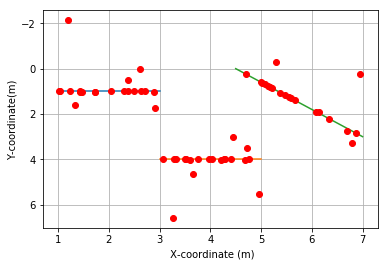

In [212]:
### Setup simulation and create plot:

# Segments (Models info): 
seg1 = [(1,1) ,(3,1)]
seg2 = [(3,4) ,(5,4)]
seg3 = [(4.5,0), (7,3)]

segments = [seg1, seg2, seg3]

# Number of points and outliers:
nPoints = 15
nOutliers = 5

stdDevX = 0.01
stdDevY = 0.01
stdDevOut = 2
                
simPoints , simLines = simulate_points(segments, nPoints, nOutliers, stdDevX, stdDevY, stdDevOut)

# Shuffle the points:
#np.random.shuffle(simPoints)


# Start by plotting the segments: 
for seg in segments: 
    
    plt.plot([seg[0][0], seg[1][0]], [seg[0][1] , seg[1][1]])
    

# Now plot the points: 
for point in simPoints: 
    
    plt.plot(point[0], point[1], 'ro')

plt.grid()
plt.gca().invert_yaxis()
plt.xlabel(' X-coordinate (m)')
plt.ylabel('Y-coordinate(m)')

## Logistic Functions: 

In [177]:
### 1. Monotonically Increasing Logistic function:
def log_inc(vec, param):     
    
    return vec**2/(vec**2 +param**2)

### Monotonically decreasing logistic function: 
def log_dec(vec, param): 
    
    return param**2/(vec**2 + param**2)

In [21]:
### Alternative function to compute Probability of Membership: 
def Pr_mem_alt(errMat,errThresh, e_tilde): 
    
#     Pr_C= np.zeros_like(errMat)
    
#     # Threshold the values in the error matrix: 
#     Pr_C[errMat > errThresh] = 0
    
#     Pr_C[errMat < errThresh] = 1
    
    errMat[errMat > errThresh] = np.Inf
    
    # Now calculate probability of membership:
    #return Pr_C
    return log_dec(errMat, e_tilde)

## Function to compute Equation of a line given two points:

In [178]:
### Description : This function returns the rho and theta parameters for the line: Theta is in radians and rho in pixels:
def get_line_eqn(p1,p2): 
    
    # First compute theta: tan(theta) = (x2 -x1)/(y1 -y2)
    # NOTE: theta is in radians
    theta = np.arctan2( (p2[0] - p1[0]), (p1[1] - p2[1]))

    # Now compute rho: 
    rho = p1[0]*np.cos(theta) + p1[1]*np.sin(theta)
    
    # Check and see if the distance from origin is a negative value:
    if rho < 0: 
        
        rho, theta = get_line_eqn(p2,p1)
    
    return (rho, theta)


### This needs to be tested out a LOT LOT LOT!!!
p1 = [1.4,1.05]
p2 = [2.6,0.99]

rho, theta = get_line_eqn(p1,p2)

print (rho,theta)


# Function returning different line equations based on order of points. This should NOT Be happening!!! Investigate this!
# Tried a temporary FIX! Need to verify this with someone!

1.11860261954 1.52083793107


## Function to get the normal distance from a given line: 

In [182]:
### Description: Get the normal distance of a point from the line. 
## Logic: Rotate the query point into the co-ordinate system of the line. The new x cordinate subtracted from the normal 
#         distance (rho) gives us the normal distance of the point from the line.
def get_normal_dist(line, point): 
    
    """
    line - Tuple containing the (rho, theta) parameters of the line
    point - Tuple containing the (x,y) co-ods of the line
    """
    
    # Rotate: 
    x_rot = np.cos(line[1])*point[0] + np.sin(line[1])*point[1]
    
    # Normal distance: x_rot - rho:
    return x_rot - line[0]

### Needs to be tested out throughly!!!
# Verify this: 
line = simLines[0]

point = (3,2)

dist = get_normal_dist(line, point)

print (dist)

1.0


In [183]:
### Description: 
def rand_sample_fit_lines(points, numLines): 
    
    #idxs = np.random.choice(len(points), (numLines,2))
    
    idxs = [(3,5) , (10,16), (12,8),(7,11), (24,36), (32,28), (25,37), (33,22),  (45,49), (51,43), (15,34) , (48,29)
           , (12,55), (16,47)]
    
    # Initialize a list for the fitted lines: 
    fitted_lines = []
    
    # Loop through the indices returned: 
    for idx in idxs:
        
        p1 = points[idx[0]]
        p2 = points[idx[1]]
        
        fitted_lines.append(get_line_eqn(p1,p2))        
    
    return fitted_lines, idxs


# Test :
# points = [(3,4), (4,5),(8,9),(12,17)]

# numLines =2

# lines = rand_sample_fit_lines(points, numLines)

# print (lines)

In [190]:
### Description: Informed Sampling Function: 

# Logic: Samples pairs of points that are close to each other in order to ensure that true lines are sampled more often: 

def info_rand_sample_fit_lines(points, numLines): 
    
    # Find the nearest neighbors of all the points in the dataset: Using a kd-tree here:
    trainData = np.asarray(points)
    kdt = KDTree(trainData, leaf_size=30, metric='euclidean')
    
    # Query the kd-tree: 
    allDistances, indices = kdt.query(trainData, k=6, return_distance = True)
    
    
    # List of the pairs of indices:
    idxs = []
    
    # Loop through and generate pairs of indices in order to fit lines: 
    for count in range(numLines): 
        
        idx1 = np.random.choice(len(points))
        
        choiceIdx2 = indices[idx1, 1:]
        
        idx2 = np.random.choice(choiceIdx2)
        
        idxs.append((idx1, idx2))
        
    
    # Initialize a list for the fitted lines: 
    fitted_lines = []
    
    # Loop through the indices returned: 
    for idx in idxs:
        
        p1 = points[idx[0]]
        p2 = points[idx[1]]
        
        fitted_lines.append(get_line_eqn(p1,p2))        
    
    return fitted_lines, idxs

## GENSAC Iterative function: 

In [229]:
### Description: The steps in this function are: 
# 1. Randomly sample pairs of points (number of pairs is a parameter) - With replacement ??
# 2. Fit lines through the pairs of points. 
# 3. Compute normal distance of each point from each line - Nested loop operation. 
# 4. Compute Probability of membership of each point in each line
# 5. Iteratively refine estimates of: 
#    - Prob validity points 
#    - Prob validity lines

def iterative_function(points, numLines, numIter, e_tilde, gamma_tilde, beta_tilde, errThresh): 
    
    """"
    Points - List of tuples, where each tuple has (x,y) co-ods of the points. 
    numLines - Number of pairs of points to be randomly sampled
    numIter - Number of ietrations for which estimates of Prob should be refined
    e_tilde - Critical distance for 50% probability of memebership in the line
    gamma_tilde - Critical fraction of valid points for 50% probability of validity of a line
    beta_tilde  - Critical fraction of valid lines for 50% probability of validity of a point
    """
    
    numPoints = len(points)
    
    # Randomly sample pairs and get the corresponding rho and theta parameters for a line fitted to the pair: 
    # Returns a list of tuples - Each tuple has the rho and theta parameters for the line: 
    lines ,idxs = info_rand_sample_fit_lines(points, numLines)
    
#     print (" The euqations of the fitted lines are: ")
#     print (lines)
#     print (" -------------------------- ")
    
    
    # Compute normal distance of each point from each line: Store in a 2-D numpy array: 
    # Points along 1st axis - Rows - axis= 0
    # Lines along 2nd axis - Columns - axis=1
    
    # Initialize the 2-D array: 
    normDist = np.zeros((numPoints, numLines))
    
    
    # Indices for the 2-D array: 
    j,k = 0,0
    
    # Loop through points:
    for point in points: 
        
        k = 0
        
        # Loop through the lines: 
        for line in lines:
            
            normDist[j,k] = get_normal_dist(line,point)
            
            # Increment the column (line) index:
            k+=1
        
        
        #Increment the row (point) index
        j += 1
        
    # Transform the Normal Distance matrix to the Probability of Membership matrix: 
    Pr_C = log_dec(normDist,e_tilde)
    #Pr_C = Pr_mem_alt(normDist, errThresh,e_tilde)
    
    #print (Pr_C)
    #print (np.sum(Pr_C, axis=0))
    
    
    ## Iteratively refine estimates of Prob of Validity - Points and Lines: 
    iterCount = 0
    
    # Initialize Probability of Validity of points and lines: 
    initProb =1
    Pr_A = initProb*np.ones((numPoints,1))
    Pr_V = np.zeros((numLines,1))
    
    
    # Initialize gamma and beta: Fractions of valid points and lines respectively: 
    gamma = np.zeros_like(Pr_V)
    beta = np.zeros_like(Pr_A)
    
    # Initialize the figure and subplots: 
    #fig, axes = plt.subplots(numLines,1, sharex = True)
    
    while iterCount < numIter: 
        
        # For each line: 
        for k in range(numLines):
            
            # Compute expected fraction of valid points: 
            gamma[k] = np.dot(Pr_A.T, Pr_C[:,k])/np.sum(Pr_A)
            
            #print (gamma[k], end=" ->")
        
            # Compute Probability of Validity: 
            Pr_V[k] = log_inc(gamma[k], gamma_tilde)
            
            
        
        # For each point: 
        for j in range(numPoints):
        
            # Compute expected fraction of valid lines in which it is a member: 
            beta[j] = np.dot(Pr_V.T, Pr_C[j,:])/np.sum(Pr_V)
            
            
            #print (beta[j], end=" ->")
            
        #print (" ")
            
        # Compute Probability of Validity: 
        Pr_A  = log_inc(beta, beta_tilde)
        
        
        iterCount +=1
        
#     # Sort the lines according to Probability of Validity:
#     idx_sort = np.argsort(Pr_V, axis=0)
    
#     print (" The equations of candidate lines and their probability of validity are: ")   

    
#     for idx in idx_sort:         
#         print (lines[int(idx)] , end = '-- >')
#         print (Pr_V[idx])
        
    return lines, Pr_A, Pr_V
    
         
    

In [231]:
### Test out the iterative function: 
import time
# Test Case - 1: Two segments - Different slopes and intercepts:
# numLines to try - 6: 

e_tilde = 0.03
errThresh = 0.06
gamma_tilde = 0.2
beta_tilde = 0.02
numLines = 20
numIter = 2


# This is just a syntax check: 
sTime = time.time()
lines , Pr_A, Pr_V = iterative_function(simPoints, numLines, numIter, e_tilde, gamma_tilde, beta_tilde,errThresh)
eTime = time.time()


print (" The time taken by the algorithm is ", eTime - sTime , " secs")

print(" The true line equations are:")
print(simLines)
print (" ------------- ")

print (" The probability of validity of the points is: ")

for i in range(len(Pr_A)):
    
    print ("Point#" , i+1, end="->")
    print (Pr_A[i])


 The time taken by the algorithm is  0.012202262878417969  secs
 The true line equations are:
[(1.0, 1.5707963267948966), (4.0, 1.5707963267948966), (3.4569957581881914, -0.69473827619670314)]
 ------------- 
 The probability of validity of the points is: 
Point# 1->[ 0.99631764]
Point# 2->[ 0.99058918]
Point# 3->[ 0.99196801]
Point# 4->[ 0.99518868]
Point# 5->[ 0.99635975]
Point# 6->[ 0.99398533]
Point# 7->[ 0.99573625]
Point# 8->[ 0.99360504]
Point# 9->[ 0.99479971]
Point# 10->[ 0.99523055]
Point# 11->[ 0.99306778]
Point# 12->[ 0.98502287]
Point# 13->[ 0.99425103]
Point# 14->[ 0.99565619]
Point# 15->[ 0.99587968]
Point# 16->[ 0.00157481]
Point# 17->[ 0.00016723]
Point# 18->[ 0.00519702]
Point# 19->[ 0.01017285]
Point# 20->[ 0.02779949]
Point# 21->[ 0.99151583]
Point# 22->[ 0.99524782]
Point# 23->[ 0.9952984]
Point# 24->[ 0.9936641]
Point# 25->[ 0.99362752]
Point# 26->[ 0.99466773]
Point# 27->[ 0.99256411]
Point# 28->[ 0.9953642]
Point# 29->[ 0.99395594]
Point# 30->[ 0.99362709]
Point

[(1.0222493267679655, 1.5451480277681244), (3.8204671338465723, 1.6195007454862571), (1.0743489230883643, 1.5433210716442745), (1.1270920128547079, 1.5118255782323726), (1.0604533779494194, 1.5130280900281887), (0.98064174338650367, 1.5912301790405368), (3.3636020776503202, -0.71726486824271518), (4.3459298684597929, 1.4886381727447269), (3.977429001362776, 1.5753915677935577), (0.85028865501152917, 1.6628616897778985), (3.9141017725127809, 1.5892730196192515)]


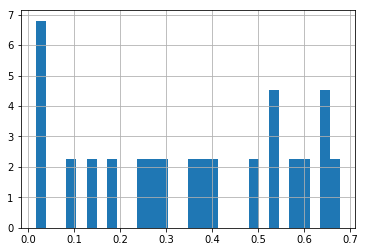

In [232]:
## Generate plot of the distribution on Probability of Validity of planes: Use histogram plot: 

num_bins = 30

# Histogram of Pr_V
nv, binsv, patchesv = plt.hist(Pr_V, num_bins, normed=1)

plt.grid()


# Identify the segments: 
idxLines = np.where(Pr_V > 0.3)[0]

estLines = []

for idx in idxLines: 

    estLines.append(lines[int(idx)])
    
    
print (estLines)

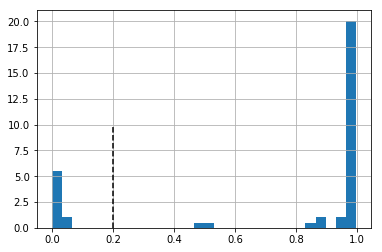

In [233]:
## Generate plot of the distribution on Probability of Validity of points: Use histogram plot: 

num_bins = 30

# Histogram of Pr_A
na, binsa, patchesa = plt.hist(Pr_A, num_bins, normed=1)

# Plot the threshold line: 
threshPrA = 0.2
threshArray = threshPrA*np.ones((50,1))
yArr = np.linspace(0, 10, 50)

plt.plot(threshArray, yArr, 'k--')
plt.grid()

Text(0,0.5,'Y-coordinate(m)')

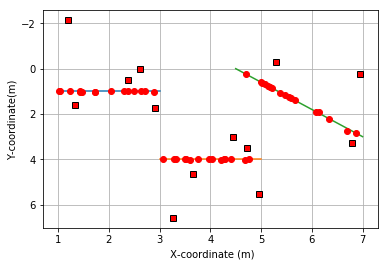

In [234]:
### Plot showing identified outliers: 

idxOutliers = np.where(Pr_A < 0.4)[0]

# Start by plotting the true segments: 
for seg in segments: 
    
    plt.plot([seg[0][0], seg[1][0]], [seg[0][1] , seg[1][1]])
    

# # Now plot the estimated segments: 
# for seg in estLines: 
    
#     plt.plot([seg[0][0], seg[1][0]], [seg[0][1] , seg[1][1]])
    

# Now plot all the points: 
for point in simPoints: 
    
    plt.plot(point[0], point[1], 'ro')
    
# Now plot only the outliers: 
for idx in idxOutliers: 
    
    plt.plot(simPoints[idx][0] , simPoints[idx][1], 'ks', markerfacecolor='none')

plt.grid()
plt.gca().invert_yaxis()
plt.xlabel(' X-coordinate (m)')
plt.ylabel('Y-coordinate(m)')

In [243]:
PrA = np.array([1,2,3,4])

print (PrA.shape)

PrC = np.array([[1,2], [3,4], [5,6], [7,8]])
                
print (PrC.shape)

dot = np.dot(PrA, PrC)

print (dot)

(4,)
(4, 2)
[50 60]
